### Importing all the library modules

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### Checking the Usage data varies over time

In [3]:
overall_data = pd.read_csv('Plotting/Full_DC.csv')
overall_data.head(3)

,Month_Year,Country,email.com,email1.com,email2.com,Users
0,Jan-22,Australia,NaN,NaN,222.0,222
1,Jan-22,Austria,NaN,NaN,240.0,240
2,Jan-22,Bangladesh,3.0,NaN,NaN,3


In [4]:
overall_data.fillna(0, inplace=True)
overall_data.insert(0, 'Date', pd.to_datetime(overall_data['Month_Year'], format="%b-%y"))

In [5]:
pivot_df_pivot = overall_data.pivot_table(index=['Date','Month_Year'], values='Users', aggfunc = 'sum').reset_index()
pivot_df_pivot.drop('Date', axis = 1)

,Month_Year,Users
0,Jan-22,14587
1,Feb-22,14873
2,Mar-22,15145
3,Apr-22,15429
4,May-22,15888
5,Jun-22,16033
6,Jul-22,16217
7,Aug-22,16333
8,Sep-22,16311
9,Oct-22,16279


### Plotting the Data

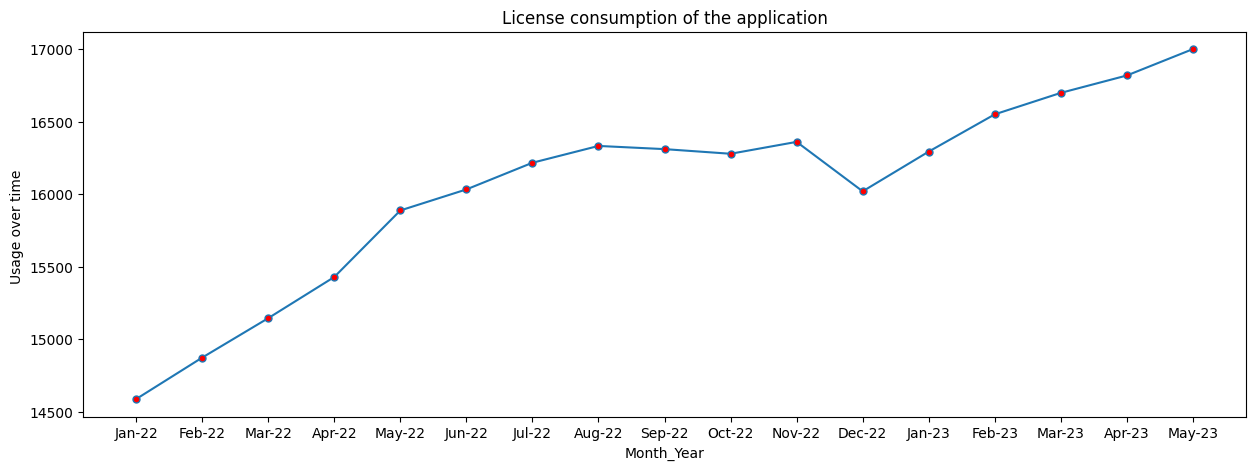

In [6]:
plt.figure(figsize=(15,5))
plt.plot(pivot_df_pivot.Month_Year, pivot_df_pivot.Users, marker='o', markerfacecolor='red', markersize=5)
plt.xlabel('Month_Year')
plt.ylabel('Usage over time ')
plt.title('License consumption of the application')
plt.show()

### Loading the data

In [7]:
data = pd.read_csv('Data/Test_DC.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month_Year  656 non-null    object 
 1   Country     656 non-null    object 
 2   email.com   427 non-null    float64
 3   email1.com  395 non-null    float64
 4   email2.com  471 non-null    float64
 5   Users       656 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 30.9+ KB


### Data Cleaning and Preprocessing

In [9]:
data['Month_Year'] = pd.to_datetime(data['Month_Year'], format='%b-%y')

In [10]:
data.isnull().any()

Month_Year    False
Country       False
email.com      True
email1.com     True
email2.com     True
Users         False
dtype: bool

In [11]:
data.fillna(0, inplace=True)

In [12]:
data.insert(0, 'year', data['Month_Year'].dt.year)
data.insert(1, 'month', data['Month_Year'].dt.month)

In [13]:
data = data.drop(['Month_Year'], axis=1)

In [14]:
data.insert(3, 'email', data['email.com'].apply(lambda x: 1 if x >= 1 else 0))
data.insert(4, 'email1', data['email1.com'].apply(lambda x: 1 if x >= 1 else 0))
data.insert(5, 'email2', data['email2.com'].apply(lambda x: 1 if x >= 1 else 0))

In [15]:
data.drop(['email.com','email1.com','email2.com'], axis = 1,inplace = True)

### Selecting the features and target

In [16]:
y = data['Users']
X = data.drop(['Users'], axis=1)

### Splitting the data for training and testing

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### Encoding the object datatype to numerical

In [18]:
encoder = ce.TargetEncoder(cols=['Country'])
X_train_encoded = encoder.fit_transform(X_train, y_train) 
X_test_encoded = encoder.transform(X_test)

### Model Selection and Fitting the data

In [19]:
#model = RandomForestRegressor(n_estimators=500)
#model = LinearRegression()
model = XGBRegressor()

model.fit(X_train_encoded, y_train)
scores = model.score(X_test_encoded, y_test)
print(f'model.score metric : {scores:.4f}%')
preds = model.predict(X_test_encoded)

e = mean_absolute_error(y_test, preds)
ep = e*100.0/y_test.mean()

print(f'mean absolute error : {e:.2f}')
mse_val = mean_squared_error(y_test, preds)
print(f'Mean squared error on test data: {mse_val:.2f}')


model.score metric : 0.9981%
mean absolute error : 9.99
Mean squared error on test data: 664.04


### Prediction of licenses that are required

In [20]:
total_usage = {}
for country in data['Country'].unique():
    country_data = data[data['Country'] == country]
    country_data_encoded = country_data.drop('Users', axis=1)
    country_data_encoded = encoder.transform(country_data_encoded) 
    country_pred = model.predict(country_data_encoded)
    total_usage[country] = int(country_pred.mean())


In [21]:
sum(total_usage.values())

15885

### To put a cap on country usage and find limits

In [22]:
overall_limit = 15000  # Setting the overall limit for the total application usage
country_limits = {}


total_predictions = 0  # Initialize total predictions

for country in data['Country'].unique():
    country_data = data[data['Country'] == country]
    country_data_encoded = country_data.drop('Users', axis=1)
    country_data_encoded = encoder.transform(country_data_encoded)
    country_pred = model.predict(country_data_encoded)
    country_limit = int(country_pred.mean())
    
    #Checking prediction over the time 
    preds += country_limit
    
    # Checking the limits of all the countries in general
    if total_predictions + country_limit > overall_limit:
        country_limit = max(0, overall_limit - total_predictions)  # Adjust the country limit accordingly
    
    country_limits[country] = country_limit
    total_predictions += country_limit

print('Country limits:', country_limits)
print(f"\n Overall licenses assigned to the country : {sum(country_limits.values())}")

Country limits: {'Australia': 229, 'Austria': 269, 'Bangladesh': 3, 'Belarus': 3, 'Belgium': 239, 'Brazil': 9, 'Canada': 491, 'China': 841, 'Croatia': 73, 'Czech Republic': 424, 'Denmark': 111, 'Finland': 170, 'France': 447, 'Germany': 2490, 'Great Britain': 693, 'Hungary': 182, 'India': 274, 'Indonesia': 13, 'Ireland': 21, 'Italy': 316, 'Japan': 235, 'Lithuania': 17, 'Malaysia': 31, 'Mexico': 7, 'Netherlands': 195, 'Norway': 144, 'Pakistan': 2, 'Poland': 526, 'Portugal': 65, 'Romania': 259, 'Russian Federation': 634, 'Saudi Arabia': 1, 'Serbia': 142, 'Slovak Republic': 229, 'Slovenia': 50, 'South Korea': 222, 'Spain': 427, 'Sweden': 3173, 'Switzerland': 739, 'Taiwan': 4, 'Thailand': 12, 'Turkey': 46, 'Ukraine': 12, 'United Arabic Emirates': 23, 'United States': 507, 'Vietnam': 0, 'New Zealand': 0, 'Kuwait': 0}

 Overall licenses assigned to the country : 15000


### getting the output in csv

In [23]:
df_country_limits = pd.DataFrame.from_dict(country_limits, orient='index', columns=['Country Limit'])

In [24]:
df_country_limits.to_csv('Output/country_limits_DC.csv', index_label='Country')

### Model Validation on unseen data

In [25]:
data_notseen = pd.read_csv("Data/valid_DC.csv")

In [26]:
data_notseen

,Month_Year,Country,email.com,email1.com,email2.com,Users
0,Mar-23,Serbia,1.0,NaN,146.0,147
1,Mar-23,Slovak Republic,152.0,7.0,74.0,233
2,Mar-23,Slovenia,NaN,NaN,68.0,68
3,Mar-23,South Korea,NaN,NaN,213.0,213
4,Mar-23,Spain,NaN,39.0,431.0,470
...,...,...,...,...,...,...
95,May-23,Turkey,50.0,NaN,NaN,50
96,May-23,Ukraine,NaN,1.0,9.0,10
97,May-23,United Arabic Emirates,24.0,NaN,NaN,24
98,May-23,United States,115.0,20.0,1375.0,1510


In [27]:
data_notseen['Month_Year'] = pd.to_datetime(data_notseen['Month_Year'], format='%b-%y')
data_notseen.fillna(0, inplace=True)
data_notseen.insert(0, 'year', data_notseen['Month_Year'].dt.year)
data_notseen.insert(1, 'month', data_notseen['Month_Year'].dt.month)
data_notseen = data_notseen.drop(['Month_Year'], axis=1)
data_notseen.insert(3, 'email', data_notseen['email.com'].apply(lambda x: 1 if x >= 1 else 0))
data_notseen.insert(4, 'email1', data_notseen['email1.com'].apply(lambda x: 1 if x >= 1 else 0))
data_notseen.insert(5, 'email2', data_notseen['email2.com'].apply(lambda x: 1 if x >= 1 else 0))
data_notseen.drop(['email.com','email1.com','email2.com'], axis = 1,inplace = True)

In [28]:
data_notseen.head(5)

,year,month,Country,email,email1,email2,Users
0,2023,3,Serbia,1,0,1,147
1,2023,3,Slovak Republic,1,1,1,233
2,2023,3,Slovenia,0,0,1,68
3,2023,3,South Korea,0,0,1,213
4,2023,3,Spain,0,1,1,470


In [29]:
y_val = data_notseen['Users']
X_val = data_notseen.drop(['Users'], axis=1)

In [30]:
X_val_encoded = encoder.transform(X_val)

In [31]:
scores = model.score(X_val_encoded, y_val)
print(f"model.score metric : {scores:.4f}%")
y_val_pred = model.predict(X_val_encoded)


e = mean_absolute_error(y_val, y_val_pred)
ep = e*100.0/y_val.mean()
print(f"mean absolute error : {e:.2f}")
mse_val = mean_squared_error(y_val, y_val_pred)
print(f'Mean squared error on validation data: {mse_val:.2f}')

model.score metric : 0.9990%
mean absolute error : 11.60
Mean squared error on validation data: 473.38
